In [13]:
import scipy
import matplotlib.pyplot as plt
from utility_programs.read_routines import SAMI
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm
from spacepy.coordinates import Coords
from spacepy.time import Ticktock

In [3]:
sami_data, times = SAMI.read_sami_data(
    "sami_dir",
    datetime.datetime(2011,5,20), datetime.datetime(2011,5,21,12), t_start_idx=1, t_end_idx=1)



In [15]:
def convert_to_cart(lats_, lons_, alts_, dtime, coord_source):
    """Converts from GEO to cartesian coordinates at a single datetime.

    Args:
        lats_ (_type_):
            Latitudes to perform the conversion at.
        lons_ (_type_):
            Longitudes to perform the conversion at.
        alts_ (int or list-like):
            Altitude(s) to perform the conversion at. When using magnetic
            sources, this needs to be 'magnetic altitude'. In geographic
            coordinates, this is the altitude above the surface of the Earth.
        dtime (datetime.datetime):
            Datetime object at which to perform the conversion.
        coord_source (str):
            Which type of coordinates to convert from. Options are currently:
            'GEO' or 'MAG'.

    Returns:
        array: 3D array of cartesian coordinates
    """
    coord_arr = []

    if len(lats_) == len(lons_) == len(alts_):
        coord_arr = list(zip(lats_, lons_, alts_/6371))
    else:
        for lat in lats_:
            for lon in lons_:
                for alt in alts_:
                    coord_arr.append([(alt + 6371)/6371, lat, lon])

    coord_arr = np.array(coord_arr)

    if coord_source == 'MAG':
        coords = Coords(coord_arr, 'MAG', 'sph')
    elif coord_source == 'GEO':
        coords = Coords(coord_arr, 'GEO', 'sph')
    else:
        raise ValueError('coord_source must be either "MAG" or "GEO"')
    coords.ticks = Ticktock([dtime for k in range(len(coord_arr))])
    newcoords = coords.convert('GEO', 'car')

    return newcoords

In [4]:
edens_t0 = sami_data['data']['edens'][:,:,:,0]
edens_t0.shape

(80, 72, 256)

In [14]:
in_lats = sami_data['grid']['mlat']
in_lons = sami_data['grid']['mlon']
in_alts = sami_data['grid']['malt']

In [5]:
len(np.unique(sami_data['grid']['mlon'].round(2)))

80

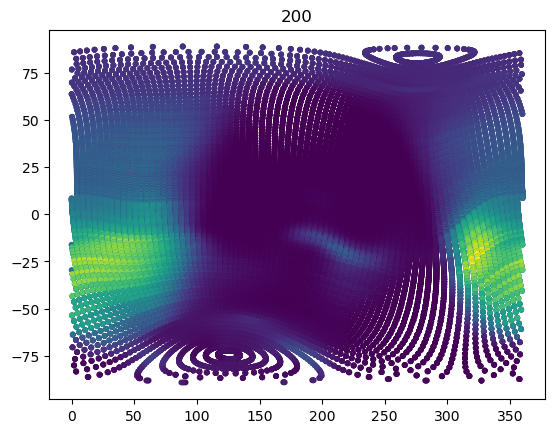

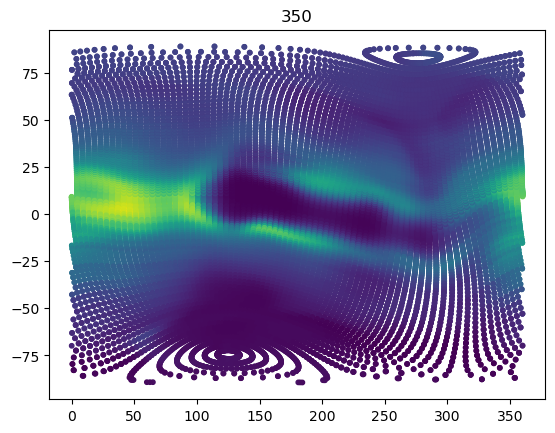

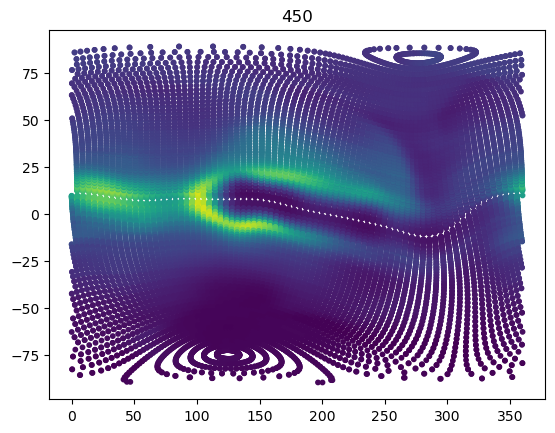

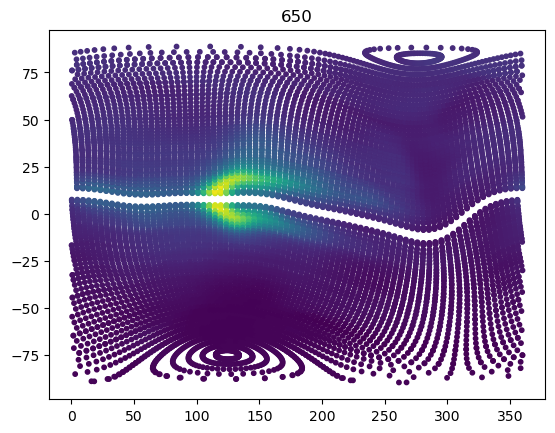

In [6]:
target_alts = [200, 350, 450, 650]

for target_alt in target_alts:
    alt_mask = np.abs(sami_data['grid']['alt'] - target_alt) < 15

    plt.scatter(sami_data['grid']['glon'][alt_mask],
            sami_data['grid']['glat'][alt_mask],
            c=edens_t0[alt_mask], s = 10)
    plt.title(target_alt)
    plt.show()

In [7]:
out_alts = np.linspace(200, 1200, 11)
out_lats = np.linspace(-65, 65, 66)
out_lons = np.linspace(-180, 180, 46)
out_alts, out_lats, out_lons

(array([ 200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000.,
        1100., 1200.]),
 array([-65., -63., -61., -59., -57., -55., -53., -51., -49., -47., -45.,
        -43., -41., -39., -37., -35., -33., -31., -29., -27., -25., -23.,
        -21., -19., -17., -15., -13., -11.,  -9.,  -7.,  -5.,  -3.,  -1.,
          1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
         23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,
         45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.]),
 array([-180., -172., -164., -156., -148., -140., -132., -124., -116.,
        -108., -100.,  -92.,  -84.,  -76.,  -68.,  -60.,  -52.,  -44.,
         -36.,  -28.,  -20.,  -12.,   -4.,    4.,   12.,   20.,   28.,
          36.,   44.,   52.,   60.,   68.,   76.,   84.,   92.,  100.,
         108.,  116.,  124.,  132.,  140.,  148.,  156.,  164.,  172.,
         180.]))

In [17]:
out_grid = convert_to_cart(out_lats, out_lons, out_alts, times[0], 'GEO')

/home/axb170054/.conda/envs/py38/lib/python3.8/site-packages/spacepy/coordinates.py:248: DeprecationWarning: No coordinate backend specified; using SpacePy. This default changed from IRBEM in version 0.4.0
  warnings.warn('No coordinate backend specified; using SpacePy.'


In [9]:
alt_mask = (sami_data['grid']['alt'] > np.min(out_alts) - 15) & (
    np.max(out_alts) < sami_data['grid']['alt'] + 15)

In [23]:
in_grid = convert_to_cart(sami_data['grid']['mlat'][alt_mask],
                          sami_data['grid']['mlon'][alt_mask],
                          sami_data['grid']['malt'][alt_mask],
                          times[0],
                          'MAG')



/home/axb170054/.conda/envs/py38/lib/python3.8/site-packages/spacepy/coordinates.py:248: DeprecationWarning: No coordinate backend specified; using SpacePy. This default changed from IRBEM in version 0.4.0
  warnings.warn('No coordinate backend specified; using SpacePy.'


In [25]:
def three_dee_interps(in_coords, in_vals, out_coords):
    interpolator = scipy.interpolate.LinearNDInterpolator(in_coords, in_vals)
    out_vals = interpolator(out_coords)
    return out_vals

In [26]:
%time out_vals = three_dee_interps(in_grid, edens_t0[alt_mask], out_grid)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/tmp/ipykernel_67235/2536748482.py:2: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  interpolator = scipy.interpolate.LinearNDInterpolator(in_coords, in_vals)


ValueError: invalid shape for input data points

In [ ]:
outs = []
for alt in in_alts:
    mask2 = np.abs(sami_data['grid']['alt'] - target_alt) < 75
    in_grid = convert_to_cart(sami_data['grid']['mlat'][mask2],
                          sami_data['grid']['mlon'][mask2],
                          sami_data['grid']['malt'][mask2],
                          times[0],
                          'MAG')
    out_grid = convert_to_cart(out_lats, out_lons, [alt], times[0], 'GEO')
    
    %time out = three_dee_interps(in_grid, edens_t0[mask2], out_grid)
    outs.append(out)

In [ ]:
%time out_vals_2 = scipy.interpolate.griddata(in_grid,
                                              edens_t0[alt_mask], out_grid)